In [1]:
import sys
import os 
sys.path.append(os.path.abspath(os.path.join("", "weights2weights")))
from copy import deepcopy
import matplotlib.pyplot as plt

In [2]:
import torch
device = "cuda:0"

In [3]:
from diffusers import DiffusionPipeline 
from peft import PeftModel
from peft.utils.save_and_load import load_peft_weights

In [4]:
from utils import load_models, unflatten

# Reconstruction error on images

1. Load one sample of LoRA weights from original dataset into model
2. Generate face with seed
3. Pass weights through whatever sae
4. Load output LoRA into another model
5. Generate face with the same seed
6. Calculate MSE and LPIPS

### 1. Loading a Model from the Dataset of Weights

In [ ]:
import gc
del model
gc.collect()
torch.cuda.empty_cache()

In [5]:
# get model with index 7 from dataset of model weights
model = torch.load(f"weights2weights/weights_datasets/identities/all_weights.pt", torch.device(device))[7, :].unsqueeze(0)

In [6]:
# get weights dimensions
weight_dimensions = torch.load(f"weights2weights/weights_datasets/weight_dimensions.pt")

In [7]:
# change working directory to work with utils functions
model_path = os.path.join(os.getcwd(), "base_model")
%cd weights2weights/weights_datasets

/net/tscratch/people/plgkingak/.cache/models--snap-research--weights2weights/snapshots/3c5604a8d5d299df416d98d3ee196603b2e2706d/weights_datasets


In [8]:
# safe model compatible with Diffusers
unflatten(model, weight_dimensions, model_path)

FileExistsError: [Errno 17] File exists: '/net/tscratch/people/plgkingak/base_model/unet'

In [11]:
pipe = DiffusionPipeline.from_pretrained("stablediffusionapi/realistic-vision-v51", 
                                         torch_dtype=torch.float16,safety_checker = None,
                                         requires_safety_checker = False).to(device)
   
pipe.unet = PeftModel.from_pretrained(pipe.unet, f"{model_path}/unet", adapter_name="identity1")
adapters_weights1 = load_peft_weights(f"{model_path}/unet", device="cuda:0")
pipe.unet.load_state_dict(adapters_weights1, strict = False)
pipe.to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.28.0",
  "_name_or_path": "stablediffusionapi/realistic-vision-v51",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

### 2. Generate face with seed

  0%|          | 0/50 [00:00<?, ?it/s]

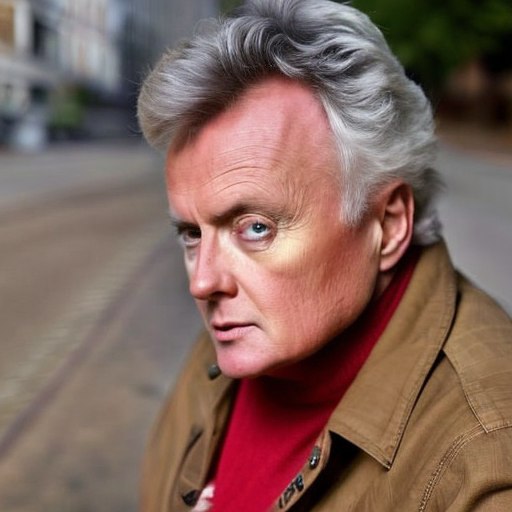

In [12]:
#random seed generator
generator = torch.Generator(device=device)
generator = generator.manual_seed(5)
latents = torch.randn(
        (1, pipe.unet.in_channels, 512 // 8, 512 // 8),
        generator = generator,
        device = device
    ).half()

#inference parameters
prompt = "sks person" #"sks person in a hat in a forest"
negative_prompt = "low quality, blurry, unfinished"
guidance_scale = 3.0
ddim_steps = 50
#run inference
image = pipe(prompt, num_inference_steps=ddim_steps, guidance_scale=guidance_scale,  negative_prompt=negative_prompt, latents = latents ).images[0]
image

### 3. Pass weights through SAE

In [13]:
from safetensors.torch import load_file

# Get weights dictionary
base_weights = load_file( f"{model_path}/unet/adapter_model.safetensors")

In [14]:
keys = [k for k in base_weights.keys() if "mid_block" in k]
values = [base_weights[k].flatten() for k in keys]
shapes = {k: base_weights[k].shape for k in keys}

In [15]:
weights_in = torch.cat(values).to(device)

In [16]:
# go back to scratch home directory
os.chdir(os.environ.get("SCRATCH"))

In [17]:
from sae import Sae
sae_path = "run_lat10000_bs4096_auxk0.1/0"
# sae_path = "run_lat1000_bs256_auxk0.0/0"
sae = Sae.load_from_disk(sae_path,device=device)

Triton not installed, using eager implementation of SAE decoder.


In [18]:
sae.eval()
out = sae(weights_in)

In [19]:
weights_out = out.sae_out

In [20]:
## if checking what happens with random values
# weights_out = torch.rand_like(weights_out)/1000

In [21]:
new_weights = deepcopy(base_weights)
start_idx = 0

for key in keys:
    shape = shapes[key]
    end_idx = start_idx + torch.prod(torch.tensor(shape)).item()  # Calculate end index
    new_weights[key] = weights_out[start_idx:end_idx].reshape(*shape)
    start_idx = end_idx

### 4. Load new weights into DiffusionPipeline

In [22]:
pipe1 = DiffusionPipeline.from_pretrained("stablediffusionapi/realistic-vision-v51", 
                                         torch_dtype=torch.float16,safety_checker = None,
                                         requires_safety_checker = False).to(device)
   
pipe1.unet = PeftModel.from_pretrained(pipe1.unet, f"{model_path}/unet", adapter_name="identity1")
# adapters_weights1 = load_peft_weights(f"{model_path}/unet", device="cuda:0")
pipe1.unet.load_state_dict(new_weights, strict = False)
pipe1.to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.28.0",
  "_name_or_path": "stablediffusionapi/realistic-vision-v51",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

### 5. Generate face with the same seed using new pipeline

  0%|          | 0/50 [00:00<?, ?it/s]

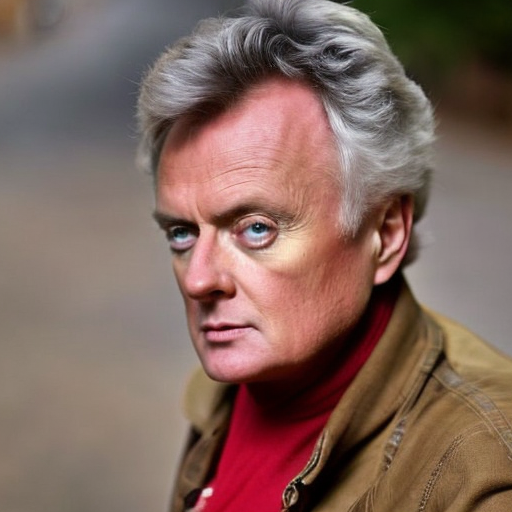

In [23]:
#run inference
image1 = pipe1(prompt, num_inference_steps=ddim_steps, guidance_scale=guidance_scale,  negative_prompt=negative_prompt, latents = latents ).images[0]
image1

### 6. Calculate MSE and LPIPS

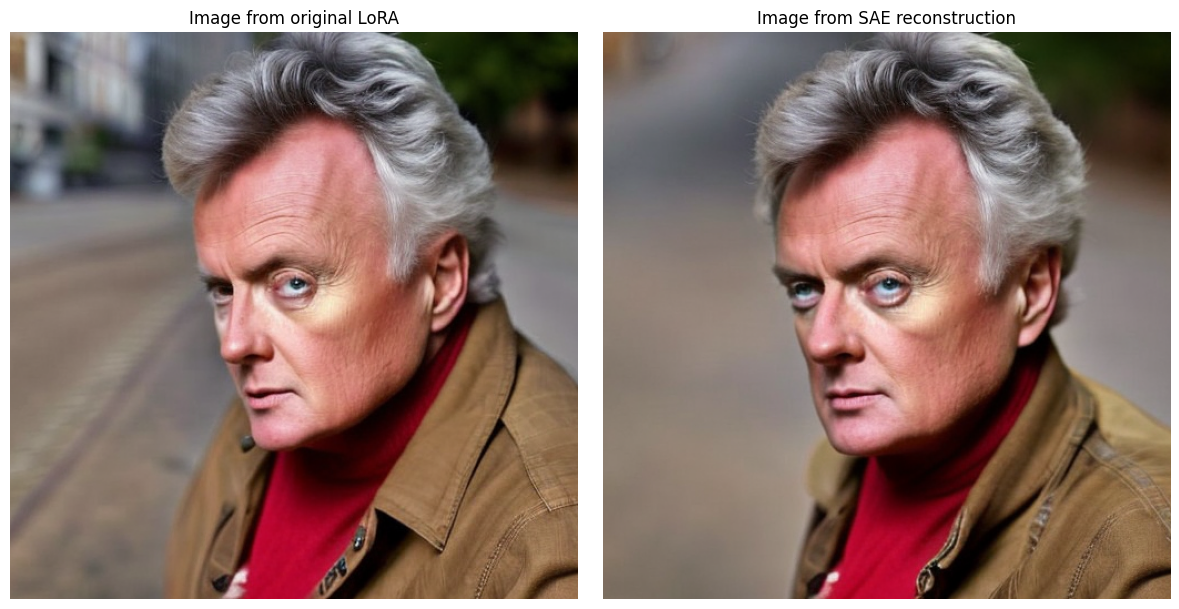

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].axis('off')
axes[0].set_title("Image from original LoRA")
axes[1].imshow(image1)
axes[1].axis('off')
axes[1].set_title("Image from SAE reconstruction")
plt.tight_layout()
plt.show()

In [25]:
import torchvision.transforms as transforms
transform = transforms.ToTensor()

In [26]:
i0, i1 = transform(image), transform(image1)

#### MSE

In [27]:
torch.mean((i0 - i1) ** 2)

tensor(0.0086)

#### LPIPS

In [ ]:
img0 = i0.unsqueeze(0)
img1 = i1.unsqueeze(0)

In [28]:

lpips = LPIPS(net_type='squeeze', normalize=True)
lpips(img0, img1)

tensor(0.1980)

In [29]:
lpips = LPIPS(net_type='vgg', normalize=True)
lpips(img0, img1)

tensor(0.3019)

In [30]:
lpips = LPIPS(net_type='alex', normalize=True)
lpips(img0, img1)

tensor(0.2625)

In [10]:
import timeit
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity as LPIPS
import torch

for net in ('squeeze', 'alex', 'vgg'):
    exec_time = timeit.timeit("lpips(img0, img1)", 
                            setup=f"from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity as LPIPS; import torch; img0 = torch.rand(1, 3, 64, 64); img1 = torch.rand(1, 3, 64, 64); lpips = LPIPS(net_type='{net}', normalize=True)", 
                            number=20)
    print(f"LPIPS {net} Execution Time: {exec_time:.6f} seconds -> {(exec_time)*160/60:.6f} minutes")

LPIPS squeeze Execution Time: 0.170342 seconds -> 0.454246 minutes
LPIPS alex Execution Time: 0.258641 seconds -> 0.689710 minutes
LPIPS vgg Execution Time: 1.612151 seconds -> 4.299069 minutes
